The path to the notebook is: /home/ucecabj/Desktop/MFI_git/MFI_class1D
The data folder is: /home/ucecabj/Desktop/MFI_git/MFI_class1D/_data_long/
The MFI grid was: 
xmin= -6.0  xmax= 6.0  nx= 501

The new PLUMED grid is: 
pl_xmin= -7.01  pl_xmax= 7.01  pl_nx= 585


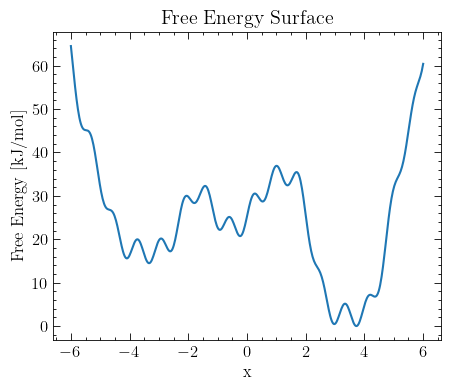

In [77]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import os

# Import the MFI library 
import MFI_lib1D as lib1
import MFI_class1D

# Set the path to the notebook and the data folder (and figures folder if needed)
if 'path_notebook' not in globals(): path_notebook = os.getcwd()
print("The path to the notebook is:", path_notebook)

if 'path_data' not in globals():
    if not os.path.isdir("_data_long"): print("\nThe data folder \"_data_long\" does not exist. Creating new folder."); os.mkdir(path_notebook + "/_data_long/"); 
    path_data = path_notebook + "/_data_long/"
print("The data folder is:", path_data)
# path_figures = "/home/ucecabj/Pictures/MFI_figures/"

# Set the plotting parameters
for _plt_parameters_ in [0]:
    from matplotlib import rc
    plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["Helvetica"], "font.size": 12, "axes.titleweight": "bold"})
    plw = 0.6  # width of (box line, tick line, ...)
    plt.rcParams.update({"axes.linewidth": plw, "figure.figsize": (4,3)}) 
    plt.rcParams.update({"xtick.top": True, "xtick.direction": "in", "xtick.major.width": plw, "xtick.minor.width": plw, "xtick.minor.visible": True, "xtick.major.size": 5})
    plt.rcParams.update({"ytick.right": True, "ytick.direction": "in", "ytick.major.width": plw, "ytick.minor.width": plw, "ytick.minor.visible": True, "ytick.major.size": 5})

# Load the grid, the FES, and the PLUMED grid. Change n_surf to select the surface.  
for _surf_parameters_ in [0]:
    [grid, y_list, y_string_list] = lib1.load_pkl(path_notebook + "/fes_list_1D")
    FES_cutoff_list = [30, 40, 40, 50, 50, 80, 60, 70, 70, 80, 80, 90, 80, 90, 90, 100, 100, 100, 110, 110]
    n_surf = 4
    y = y_list[n_surf]
    FES_cutoff = FES_cutoff_list[n_surf]
    y_string = y_string_list[n_surf]  
    dx, dy = grid[1] - grid[0], np.gradient(y, grid[1] - grid[0]) 
    [pl_x, pl_min, pl_max, pl_n, pl_ext] = lib1.get_plumed_grid_1D(grid, -7, 7, print_info=True)
    plt.figure(figsize=(5,4)); plt.plot(grid, y); plt.xlabel("x"); plt.ylabel("Free Energy [kJ/mol]"); plt.title("Free Energy Surface"); plt.show()

In [16]:
os.chdir(path_notebook); reload(MFI_class1D); reload(lib1); pass

### Example simulation

In [4]:
# Stimulation path
path_simulation = path_data + "test/"

# Select surface
n_surf = 4
y, y_string, FES_cutoff = y_list[n_surf], y_string_list[n_surf], FES_cutoff_list[n_surf]

# Set default parameters
default_params = {	"grid":grid, "y":y, "bw":dx*1.5, "periodic":False, # "dy":dy, "initial_position":[0,0], 
					"System":y_string, "pl_grid":pl_x, "simulation_steps": 2_000_000, 
					"position_pace":50, "metad_pace":500, "n_pos_per_window":10, "metad_width":0.1, "metad_height":5, "biasfactor":50 , 
                    "len_error_list":100, "FES_cutoff":FES_cutoff, "calculate_FES_st_dev":True, "bootstrap_iter":50, 
                    "save_results":True, "save_mfi_instance":True, "simulation_folder_path": path_simulation, "print_info": True}


Running Langevin dynamics: n_steps=2,000,000, ipos=-3.97, Pos_t=50, T=1, t_Tot=10.00ns
sigma=0.1, h=5, bf=50, Gaus_t=500
Static bias used: None 

| 100% | Simulated time: 10.0002ns | Total time: 21 sec | Finished at 11:10:31                                                         

Langevin dynamics finished in 21 sec.
| 100% | AAD: 0.389 [kJ/mol] | Total time: 30 sec                                                            


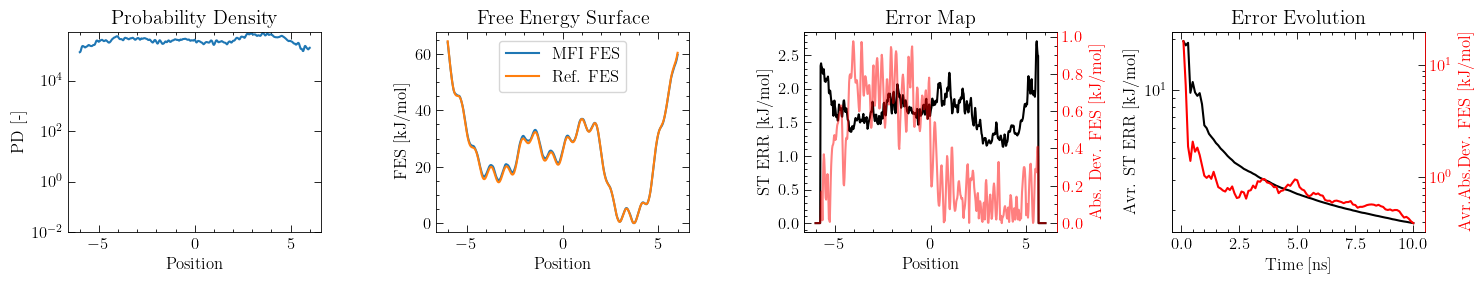

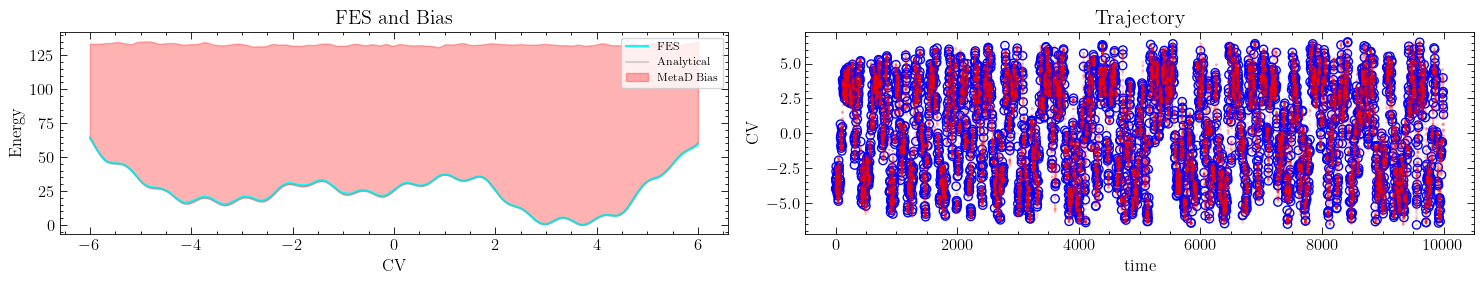

In [5]:
## Load MFI object
MFI = MFI_class1D.MFI1D(**default_params)

## Run the simulation
MFI.run_simulation()

## Analyse the data
MFI.analyse_data()

## Plot the results and save the data for later use
MFI.plot_results()
lib1.plot_FES_Bias_and_Traj(grid=MFI.grid, fes=MFI.FES, metad_bias=MFI.Bias, position=MFI.position, hills=MFI.hills, y=MFI.y )

### Run Multiple Long Simulations and analysis (for statistical analysis)

In [10]:
# Set default parameters
default_params = {	"grid":grid, "y":y, "bw":dx*1.5, "periodic":False, # "dy":dy, "initial_position":[0,0], 
					"System":y_string, "pl_grid":pl_x, "simulation_steps": 20_000_000, 
					"position_pace":50, "metad_pace":500, "n_pos_per_window":10, 
     				"metad_width":0.1, "metad_height":5, "biasfactor":50 , 
					"len_error_list":100, "FES_cutoff":FES_cutoff, 
                    "save_error_progression": True, "save_force_terms": True, 
     				"simulation_folder_path": path_simulation, "print_info": True}

In [91]:

# Loop over all surfaces
# for n_surf in [13, 14, 15, 16, 17, 18, 19]:
# for n_surf in range(20):
for n_surf in [3]:
    y, y_string, FES_cutoff = y_list[n_surf], y_string_list[n_surf], FES_cutoff_list[n_surf]
    print(f"\n~~~~~~ Surface {n_surf} ~~~~~~")

    # loop over simulations
    n_sim = 15 if n_surf != 4 else 23    
    for i in range(1,n_sim):
        
        print(f"~~~~~~ Simulation {i} ~~~~~~")
        
        sim_id = f"_{i}_100ns"
        new_path = path_data + f"S{n_surf}/simulation{sim_id}/"
        
        #check if directory exists
        if os.path.isdir(new_path): pass
        else: os.mkdir(new_path)
        os.chdir(new_path)
        
        new_params = default_params.copy()
        new_params.update({"simulation_folder_path":new_path, "ID":sim_id})
        new_params.update({"y":y, "System":y_string, "FES_cutoff":FES_cutoff})

        ## Load MFI object
        MFI = MFI_class1D.MFI1D(**new_params)

        ## check if HILLS file exists
        if os.path.isfile(MFI.hills_file): print("HILLS file exists, skipping simulation")
        else: MFI.run_simulation()
            
        if os.path.isfile(f"error_progression{sim_id}.pkl"): print("Data file exists, skipping analysis")
        else:
            MFI.analyse_data()
            # MFI.plot_results()
            
        



~~~~~~ Surface 3 ~~~~~~
~~~~~~ Simulation 1 ~~~~~~
HILLS file exists, skipping simulation
Data file exists, skipping analysis
~~~~~~ Simulation 2 ~~~~~~
HILLS file exists, skipping simulation
Data file exists, skipping analysis
~~~~~~ Simulation 3 ~~~~~~
HILLS file exists, skipping simulation
Data file exists, skipping analysis
~~~~~~ Simulation 4 ~~~~~~
HILLS file exists, skipping simulation
Data file exists, skipping analysis
~~~~~~ Simulation 5 ~~~~~~
HILLS file exists, skipping simulation
Data file exists, skipping analysis
~~~~~~ Simulation 6 ~~~~~~
HILLS file exists, skipping simulation
Data file exists, skipping analysis
~~~~~~ Simulation 7 ~~~~~~
HILLS file exists, skipping simulation
Data file exists, skipping analysis
~~~~~~ Simulation 8 ~~~~~~
HILLS file exists, skipping simulation
Data file exists, skipping analysis
~~~~~~ Simulation 9 ~~~~~~
HILLS file exists, skipping simulation
Data file exists, skipping analysis
~~~~~~ Simulation 10 ~~~~~~
HILLS file exists, skipping s

### Get Mean and ST ERR of Error Progression

t=[1.00,100.00] | Final avr: AOFE=0.480, AAD=0.063


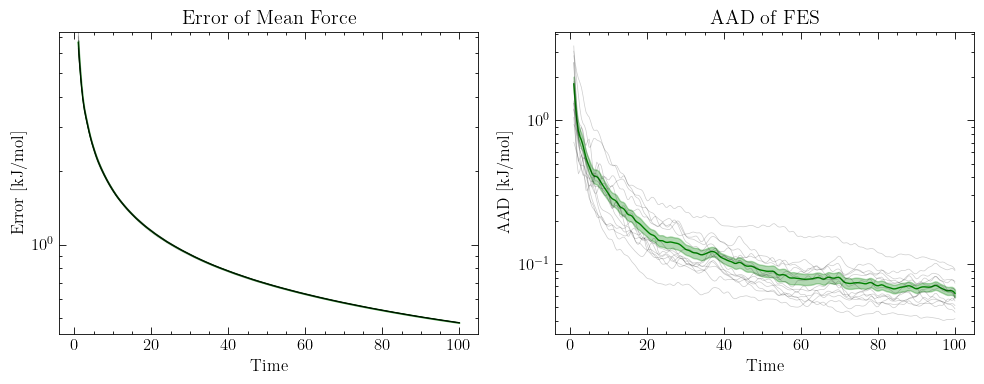

In [94]:
n_surf = 4
total_campaigns = 14
time_budget = 100

lib1.get_avr_error_prog(path_data, n_surf=n_surf, total_campaigns=total_campaigns, time_budget=time_budget, simulation_type="long", show_plot=True)

